# Deep Q-Network (DQN)

**Description:** Implementing DQN algorithm on the Robot Navigation Problem.

## Introduction

**Deep Q-Network (DQN)** is a model-free off-policy algorithm for learning discrete actions.

It uses neural networks to apply function approximation, to estimate the Q-function while avoiding convergence problems in the case of continous actions space, states space or both.

It uses a method called replayed memory, which represents a memory buffer for storing the experiences of the agent.

## Problem

We are trying to solve the **Robot Navigation** problem.
In this setting, we can assume taking three actions: [Forward, LeftTurn, RightTurn].


The implementation of the algorithm is carried out in the rest of the file.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

%matplotlib inline
from matplotlib import pyplot as plt

import gym
import bot3RLNav
import cv2


2022-11-17 16:28:56.131230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 16:28:56.275734: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-17 16:28:56.308705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/hu

In [3]:

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.n_actions = action_size
        '''
        # "lr" : learning rate
        # "gamma": discount factor
        # "decay_rate": exponential decay rate of the exploration probability
        # "batch_size": size of the sampled experiences to train the DNN
        # "epsilon:" exploration probability
        '''
        self.lr = 0.001
        self.gamma = 0.99
        self.epsilon = 1.0
        self.decay_rate = 0.005
        self.batch_size = 32
        
        # Define memory buffer for experiences storage
        self.memory_buffer= list()
        # Store the last 2000  time steps
        self.max_memory_buffer = 2000
        
        # Create a model having two hidden layers of 24 units
        # The first layer has the size of "state space"
        # The last layer has the size of "actions space"
        self.model = Sequential([
            Dense(units=24,input_dim=state_size, activation = 'relu'),
            Dense(units=24,activation = 'relu'),
            Dense(units=action_size, activation = 'linear')
        ])
        self.model.compile(loss="mse", optimizer = Adam(lr=self.lr))

    def get_action(self, current_state):
        if np.random.uniform(0,1) < self.epsilon:
            return np.random.choice(range(self.n_actions))
        q_values = self.model.predict(current_state)[0]
        return np.argmax(q_values)

    def update_epsilon(self):
        # Update epsilon at episode termination
        self.epsilon = self.epsilon*np.exp(-self.decay_rate)
        print("epsilon:", self.epsilon)

    def store_episode(self, current_state, action, reward, next_state, done):
        self.memory_buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done":done,
        })
        # @ memory buffer size exceeds the max. size, remove the first element (oldest)
        if len(self.memory_buffer) > self.max_memory_buffer:
            self.memory_buffer.pop(0)

    def train(self, batch_size):
        # Select batch size of experience, after shuffling the memory buffer
        np.random.shuffle(self.memory_buffer)
        batch_sample = self.memory_buffer[0:self.batch_size] 

In [4]:
env = gym.make('bot3RLNav/DiscreteWorld-v2', map_file="data/map01.jpg", robot_file="data/robot.png")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_episodes = 100
max_iter = 800

agent = DQNAgent(state_size, action_size)
total_steps = 0


/home/sohaila/.local/lib/python3.10/site-packages/gym/envs/registration.py:568: UserWarning: WARN: The environment bot3RLNav/DiscreteWorld-v2 is out of date. You should consider upgrading to version `v5`.
  logger.warn(


{0: [0, -1], 1: [0, 0], 2: [0, 1], 3: [1, -1], 4: [1, 0], 5: [1, 1], 6: [2, -1], 7: [2, 0], 8: [2, 1], 9: [3, -1], 10: [3, 0], 11: [3, 1], 12: [4, -1], 13: [4, 0], 14: [4, 1]}


2022-11-17 16:28:58.997987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sohaila/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:
2022-11-17 16:28:58.998160: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 16:28:58.998188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sohaila-Legion): /proc/driver/nvidia/version does not exist
2022-11-17 16:28:58.998716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

In [5]:
episode_rewards = []
mean_rewards = []
for episode in range(n_episodes):
    current_state = env.reset(options=dict(reset=False))
    current_state = np.array([current_state])

    total_rewards_per_episode = 0
    for step in range(max_iter):
        total_steps += 1
        name = "bot3"
        cv2.namedWindow(name)
        rate = 50 # frame rate in ms
        frame = env.render(mode="rgb_array")
        cv2.imshow("bot3", frame)
        cv2.waitKey(rate)

        action = agent.get_action(current_state)
        next_state, reward, done, _ = env.step(action)
        # print("action: ", env.actions[action], "state: ",next_state, "reward: ",reward)
        next_state = np.array([next_state])
        agent.store_episode(current_state, action, reward, next_state, done)
        total_rewards_per_episode += reward

        if done:
            agent.update_epsilon()
            break
        current_state = next_state
  
    episode_rewards.append(total_rewards_per_episode)
    total_mean_rewards = np.mean(episode_rewards)
    mean_rewards.append(total_mean_rewards)
    print("Episode: ", episode)
    print("Rewards mean: ", total_mean_rewards)

    if total_steps >= agent.batch_size:
        agent.train(batch_size=agent.batch_size)



qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/sohaila/.local/lib/python3.10/site-packages/cv2/qt/plugins"


epsilon: 0.9950124791926823
Episode:  0
Rewards mean:  445.67630672087796
1/1 [==============================] - 0s 11ms/step
epsilon: 0.9900498337491681
Episode:  1
Rewards mean:  872.8982630869957
1/1 [==============================] - 0s 11ms/step
epsilon: 0.9851119396030628
Episode:  2
Rewards mean:  728.4242369929198
1/1 [==============================] - 0s 11ms/step
epsilon: 0.9801986733067554
Episode:  3
Rewards mean:  600.1714210079518
1/1 [==============================] - 0s 11ms/step
Episode:  4
Rewards mean:  716.7379158728569
1/1 [==============================] - 0s 10ms/step
epsilon: 0.9753099120283327
Episode:  5
Rewards mean:  635.5851536192256
1/1 [==============================] - 0s 11ms/step
epsilon: 0.9704455335485083
Episode:  6
Rewards mean:  577.0486107768834
1/1 [==============================] - 0s 11ms/step
epsilon: 0.9656054162575666
Episode:  7
Rewards mean:  550.1106991537416
1/1 [==============================] - 0s 12ms/step
epsilon: 0.9607894391523233

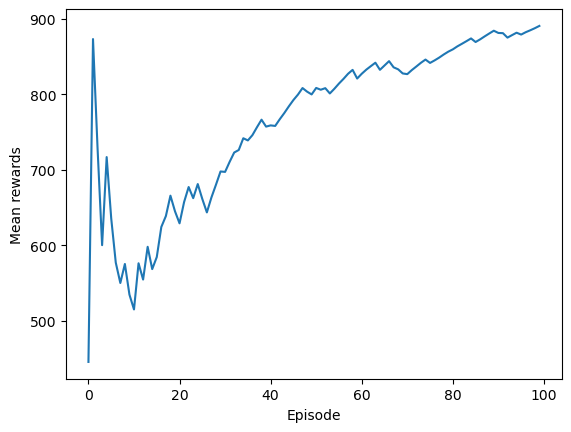

In [6]:
# Plot rewards mean against episodes
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.show()